In [12]:
#opening libs


import re
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from UNet_class_and_functions import* #this is not a library, but the python code storing UNet class and other useful functions
from skimage.morphology import local_maxima

In [2]:
#loading data (cropped and segmented wings)

crop_wing_directory = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/sorted/cropped_wings"
seg_wing_directory = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/sorted/segmented_wings"

crop_content = list_directory_contents(crop_wing_directory)
seg_content = list_directory_contents(seg_wing_directory)

crops = []
segs = []

for name in crop_content:
    crop = cv2.imread(crop_wing_directory + '/' + name)
    crop = cv2.cvtColor(crop,cv2.COLOR_BGR2RGB)

    crops.append(crop)

    seg = cv2.imread(seg_wing_directory + '/' + name) #they got the same name in my case, but this is easier with this
    seg = cv2.cvtColor(seg,cv2.COLOR_BGR2RGB)

    segs.append(seg)
    # plt.imshow(crop)
    # plt.show()

    # plt.imshow(seg)
    # plt.show()
    # break


In [7]:
#preparing for inference

crops_t = []

for crop in crops:
    crop_t = torch.Tensor(crop.transpose(2,0,1)/255).unsqueeze(0)
    crops_t.append(crop_t)



segs_t = []

for seg in segs:
    seg_t = torch.Tensor(seg.transpose(2,0,1)/255).unsqueeze(0)
    segs_t.append(seg_t)


In [8]:
#loading model

#loading the model

model_name = "UNet_150_epoch_lr=0.001_seed=58_func=pow_param=30"
model_directory = "/home/gabriel/Documents/TR DIMA/data_clean/models"

model_load = torch.load(model_directory + '/'  + model_name + '.pth',weights_only = False)
model_load.to('cuda') #remove this if you are not using cuda
model_load.eval()  # model to evaluation mode


UNet(
  (encoder1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_

In [9]:
#doing the inference and putting outputs in a list
out_crops = []
out_segs = []

for crop_t in crops_t:
    crop_t = crop_t.to('cuda')

    output = model_load(crop_t).cpu().squeeze(0).detach().numpy().transpose(1,2,0)
    out_crops.append(output)

for seg_t in segs_t:
    seg_t = seg_t.to('cuda')

    output = model_load(seg_t).cpu().squeeze(0).detach().numpy().transpose(1,2,0)
    out_segs.append(output)


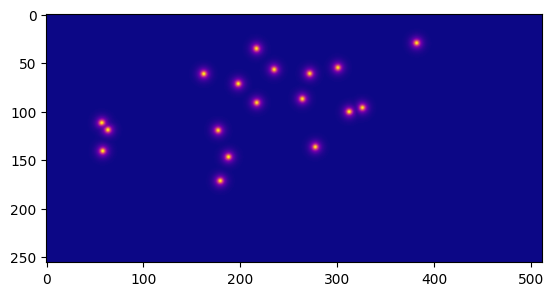

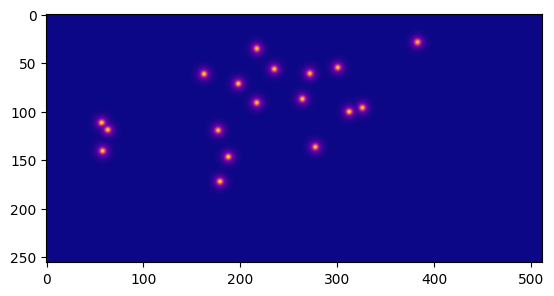

In [11]:
#checking outputs

for im in out_crops:
    plt.imshow(im,cmap = 'plasma')
    plt.show()
    break

for im in out_segs:
    plt.imshow(im,cmap = 'plasma')
    plt.show()
    break

In [18]:
#computing annotations, and display on some images, then saving the plot on separated folders

seg_annotations = []
crop_annotations = []

for im in out_crops:
    im = im.squeeze(axis = 2)
    maximas = np.argwhere(local_maxima(im) == True)
    scores = np.array([im[pt[0],pt[1]] for pt in maximas])
    sorter = np.argsort(scores)
    maximas = maximas[sorter,:]
    maximas = maximas[-18:,:]
    crop_annotations.append(maximas)

for im in out_segs:
    im = im.squeeze(axis = 2)
    maximas = np.argwhere(local_maxima(im) == True)
    scores = np.array([im[pt[0],pt[1]] for pt in maximas])
    sorter = np.argsort(scores)
    maximas = maximas[sorter,:]
    maximas = maximas[-18:,:]
    seg_annotations.append(maximas)


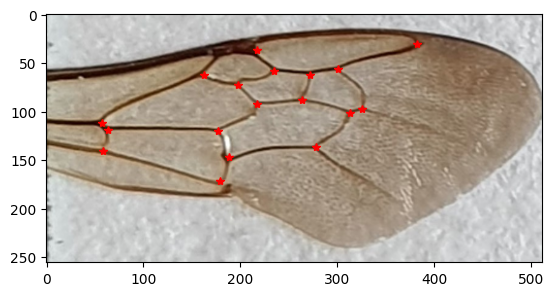

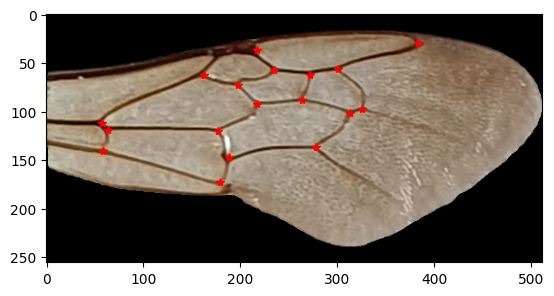

In [21]:
#testing for few images

for index,image in enumerate(crops):
    plt.imshow(image)
    current_annotation = crop_annotations[index]
    plt.plot(current_annotation[:,1],current_annotation[:,0],'r*')
    plt.show()
    break

for index,image in enumerate(segs):
    plt.imshow(image)
    current_annotation = seg_annotations[index]
    plt.plot(current_annotation[:,1],current_annotation[:,0],'r*')
    plt.show()
    break

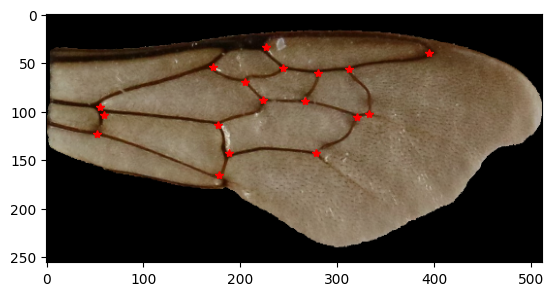

In [25]:
#saving the results in separate folder

crop_results = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/sorted/results/crop"
seg_results = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/sorted/results/seg"


for index,image in enumerate(crops):
    plt.clf()
    plt.imshow(image)
    current_annotation = crop_annotations[index]
    plt.plot(current_annotation[:,1],current_annotation[:,0],'r*')
    plt.savefig(crop_results + '/' + f"{index}" + ".png")


for index,image in enumerate(segs):
    plt.clf()
    plt.imshow(image)
    current_annotation = seg_annotations[index]
    plt.plot(current_annotation[:,1],current_annotation[:,0],'r*')
    plt.savefig(seg_results + '/' + f"{index}" + ".png")
